## French daily streamflow data download and pre-processing:

#### The main objective of this script is to download and pre-process  the available streamflow data from the French official authority and have a close look at their gaps:

Written by: Thiago Victor Medeiros do Nascimento

References:

1. Eau France and Hydroportal: https://www.hydro.eaufrance.fr/rechercher/entites-hydrometriques

In [1]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
from plotly.offline import plot
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import datetime
import tqdm as tqdm
import os
import glob
warnings.simplefilter(action='ignore', category=Warning)


%config Completer.use_jedi = False # This improve the auto-fill function

#### France does not provide one simple way to download all data at once, hence we can work with selenium to automatize the process:

1. First we need to have a look at the dataset and select with a filter select the lsit of stations to be downloaded:

In [2]:
path = r"C:\Users\nascimth\Documents\Thiago\Eawag\Python\Datasets"
os.chdir(path)
os.getcwd()

'C:\\Users\\nascimth\\Documents\\Thiago\\Eawag\\Python\\Datasets'

In [3]:
network = pd.read_csv(r'France\stations\stationshydrofrance_all.csv',encoding='latin-1', skiprows=0, usecols = ['CdStationH', 'CdAncieRef', 
                      'TypStation', 'timePositi', 'DtFermetur', 'xcoord',
                      'ycoord'])


names = ['Code', 'CodeOld', 'Type', 'StartDate', 'EndDate', 'xcoord', 'ycoord']

network.columns = names


network["StartDate"].replace({'T': ' '}, regex=True, inplace=True)
network["StartDate"].replace({'Z': ' '}, regex=True, inplace=True)
network["EndDate"].replace({'T': ' '}, regex=True, inplace=True)
network["EndDate"].replace({'Z': ' '}, regex=True, inplace=True)

network["StartDate"] = pd.to_datetime(network['StartDate'], format='%Y/%m/%d')
network["EndDate"] = pd.to_datetime(network['EndDate'], format='%Y/%m/%d')

network

Code   CodeOld Type           StartDate             EndDate  \
0     A021005050  A0210050  STD 1899-12-30 23:50:39                 NaT   
1     A022020001  A0220200  STD 1993-01-24 23:00:00                 NaT   
2     A022065001  A0220650  STD 1993-01-24 23:00:00 1996-04-12 10:00:00   
3     A023010001  A0220570  STD 1993-04-01 22:00:00 1996-04-12 10:00:00   
4     A023020001  A0230201  STD 1993-02-03 23:00:00 1996-04-12 10:00:00   
...          ...       ...  ...                 ...                 ...   
5175  Y980000301  Y9806210  STD 1971-05-31 23:00:00 1989-04-01 10:00:00   
5176  Y980000302  Y9800003  STD 2020-06-16 22:00:00                 NaT   
5177  Y982000101  Y9825010  STD 1968-12-31 23:00:00 1980-12-01 11:00:00   
5178  Y991000101  Y9905010  STD 1983-11-15 23:00:00 1988-04-30 22:00:00   
5179  Z600000101  N7120020  STD 2009-12-31 23:00:00                 NaT   

        xcoord     ycoord  
0     7.606153  47.556970  
1     7.528982  47.564377  
2     7.508168  47.587489  
3     7.545294  47.603575  
4     7.556488  47.596980  
...        ...        ...  
5175  9.237134  41.596813  
5176  9.237163  41.596406  
5177  9.204303  41.444451  
5178  9.146374  41.464203  
5179 -1.327887  45.913912  

[5180 rows x 7 columns]

2. Now we can apply some filters to check our start and end dates:

In [4]:
network_cond_1 = network[network.EndDate > "2000"]
network_cond_1

Code   CodeOld Type           StartDate             EndDate  \
9     A034002201  A0340020  STD 1997-12-08 23:00:00 2001-10-31 11:00:00   
10    A034030201  A0340300  STD 1998-04-05 22:00:00 2001-10-31 13:30:00   
14    A041030101  A0410301  STD 2007-07-15 22:00:00 2019-03-19 23:00:00   
15    A043030001  A0430310  STD 2004-03-24 23:00:00 2006-07-07 22:00:00   
16    A052033001  A0430311  STD 2005-03-29 22:00:00 2017-09-07 22:00:00   
...          ...       ...  ...                 ...                 ...   
5093  Y661401001  Y6614010  STD 1952-12-31 23:00:00 2020-10-03 22:00:00   
5094  Y661405001  Y6614050  STD 1996-11-20 23:00:00 2001-02-20 23:00:00   
5116  Y741000201  Y7416010  STD 1979-10-31 23:00:00 2000-01-09 23:00:00   
5130  Y832000201  Y8324010  STD 1966-06-30 23:00:00 2004-05-06 16:00:00   
5140  Y881000102  Y8814010  STD 1965-12-31 23:00:00 2012-04-30 10:00:00   

        xcoord     ycoord  
9     7.402300  47.789660  
10    7.480875  47.758724  
14    7.557678  48.097190  
15    7.650201  48.266571  
16    7.665815  48.289669  
...        ...        ...  
5093  7.589489  44.051777  
5094  7.563346  44.013538  
5116  9.402798  42.972504  
5130  8.839758  41.980221  
5140  9.076033  41.725826  

[659 rows x 7 columns]

In [5]:
network_cond_2 = network_cond_1[network_cond_1.StartDate < "1995"]
network_cond_2

Code   CodeOld Type           StartDate             EndDate  \
37    A112020001  A1122010  STD 1962-10-08 23:00:00 2008-01-10 10:20:00   
39    A113030001  A1133011  STD 1984-08-30 22:00:00 2001-03-20 09:30:00   
42    A115084001  A1152010  STD 1969-07-31 23:00:00 2001-01-09 10:30:00   
73    A133043201  A1304320  STD 1981-05-26 22:00:00 2001-10-31 22:30:00   
81    A143069001  A1436910  STD 1979-11-08 23:00:00 2001-06-05 08:50:00   
...          ...       ...  ...                 ...                 ...   
5082  Y644201001  Y6442010  STD 1985-12-31 23:00:00 2018-06-25 08:00:00   
5093  Y661401001  Y6614010  STD 1952-12-31 23:00:00 2020-10-03 22:00:00   
5116  Y741000201  Y7416010  STD 1979-10-31 23:00:00 2000-01-09 23:00:00   
5130  Y832000201  Y8324010  STD 1966-06-30 23:00:00 2004-05-06 16:00:00   
5140  Y881000102  Y8814010  STD 1965-12-31 23:00:00 2012-04-30 10:00:00   

        xcoord     ycoord  
37    7.108240  47.631656  
39    7.104532  47.654860  
42    7.246258  47.672408  
73    7.376394  47.790524  
81    7.079793  47.851523  
...        ...        ...  
5082  7.200065  43.664923  
5093  7.589489  44.051777  
5116  9.402798  42.972504  
5130  8.839758  41.980221  
5140  9.076033  41.725826  

[409 rows x 7 columns]

In [6]:
network_cond_3 = network_cond_2[~network_cond_2.CodeOld.isna()]
network_cond_3

Code   CodeOld Type           StartDate             EndDate  \
37    A112020001  A1122010  STD 1962-10-08 23:00:00 2008-01-10 10:20:00   
39    A113030001  A1133011  STD 1984-08-30 22:00:00 2001-03-20 09:30:00   
42    A115084001  A1152010  STD 1969-07-31 23:00:00 2001-01-09 10:30:00   
73    A133043201  A1304320  STD 1981-05-26 22:00:00 2001-10-31 22:30:00   
81    A143069001  A1436910  STD 1979-11-08 23:00:00 2001-06-05 08:50:00   
...          ...       ...  ...                 ...                 ...   
5082  Y644201001  Y6442010  STD 1985-12-31 23:00:00 2018-06-25 08:00:00   
5093  Y661401001  Y6614010  STD 1952-12-31 23:00:00 2020-10-03 22:00:00   
5116  Y741000201  Y7416010  STD 1979-10-31 23:00:00 2000-01-09 23:00:00   
5130  Y832000201  Y8324010  STD 1966-06-30 23:00:00 2004-05-06 16:00:00   
5140  Y881000102  Y8814010  STD 1965-12-31 23:00:00 2012-04-30 10:00:00   

        xcoord     ycoord  
37    7.108240  47.631656  
39    7.104532  47.654860  
42    7.246258  47.672408  
73    7.376394  47.790524  
81    7.079793  47.851523  
...        ...        ...  
5082  7.200065  43.664923  
5093  7.589489  44.051777  
5116  9.402798  42.972504  
5130  8.839758  41.980221  
5140  9.076033  41.725826  

[399 rows x 7 columns]

In [7]:
final_stations = network_cond_3.Code.tolist()

#### Here we can import our geospatialfunctions module and use some functions for ploting and pre-processing:

In [8]:
import geospatialfunctions as geospatialfunctions

In [9]:
coords = network_cond_2[["xcoord", "ycoord", "Code"]]
coords.set_index('Code', inplace = True)

coords.astype(float)
coords

xcoord     ycoord
Code                           
A112020001  7.108240  47.631656
A113030001  7.104532  47.654860
A115084001  7.246258  47.672408
A133043201  7.376394  47.790524
A143069001  7.079793  47.851523
...              ...        ...
Y644201001  7.200065  43.664923
Y661401001  7.589489  44.051777
Y741000201  9.402798  42.972504
Y832000201  8.839758  41.980221
Y881000102  9.076033  41.725826

[409 rows x 2 columns]

(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

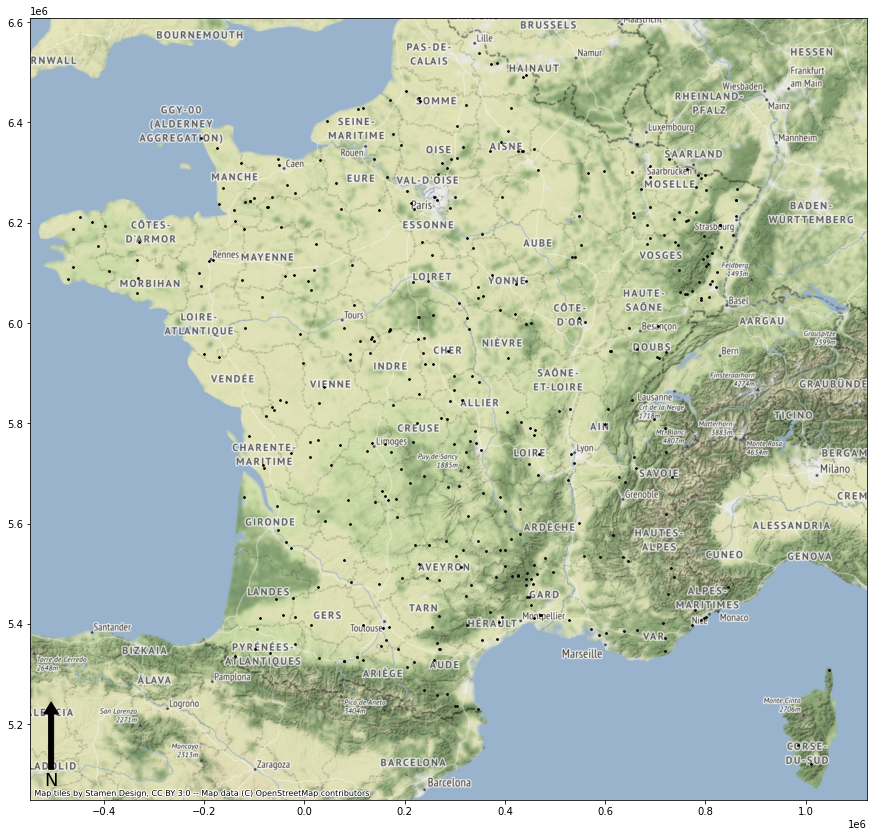

In [10]:
geospatialfunctions.plotpointsmap(coords)

3. Now we can import some libraries from the selenium module and proceed with the download:
#### The download will be automatized by the selenium module, and will go through each station selected in the first filter, and proceed with the data retrieval. 

In [11]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd

In [ ]:
URL = "https://www.hydro.eaufrance.fr/stationhydro/station_name/series"


#É necessário ter o arquivo webdriver num diretório conhecido, ou no diretório corrente: 
driver = webdriver.Chrome()
for station in tqdm.tqdm(final_stations):
    path = URL.replace("station_name", station)
    
    # First we get the URL:
    driver.get(path)
    
    
    # There is the possibility of having stations classified as deprecated stations and then you have to do an etra step 
    # to retrive it
    try:
        # First you set the starting and ending date:
        driver.find_element_by_xpath('//*[@id="hydro_series_startAt"]').send_keys("01/09/1970")
        driver.find_element_by_xpath('//*[@id="hydro_series_endAt"]').send_keys("30/09/2022")
        
        # This step is just for refresh:
        driver.find_element_by_xpath('//*[@id="hydro_series_endAt"]').send_keys(Keys.RETURN)
    
        # Those following are other bottons needed to be clicked or ticked:
        driver.find_element_by_xpath('//*[@id="hydro_series_variableType_1"]').click()
        driver.find_element_by_xpath('//*[@id="hydro_series_dailyVariable"]/option[3]').click()
        driver.find_element_by_xpath('//*[@id="hydro_series_step"]').send_keys("1")

        # Now you click in the search bottom:
        driver.find_element_by_xpath('/html/body/div[2]/main/div/div[2]/div/div[1]/div[2]/div/form/div[5]/button').click()

        # As the data will need to be refreshed on the page you will need to set a longer wait than the default otherwise
        # the bottoms will not appear:
        driver.implicitly_wait(10)
        
        # These are bottoms for set the units, change to the table format, and finally donwload the data:
        button = driver.find_element_by_xpath("/html/body/div[2]/main/div/div[2]/div/div[2]/div/div/div[4]/div/div[1]/div/div[1]/div/button[1]")
        driver.execute_script("arguments[0].click();", button)

        button = driver.find_element_by_xpath("/html/body/div[2]/main/div/div[2]/div/div[2]/div/div/div[2]/div/div/a[2]")
        driver.execute_script("arguments[0].click();", button)

        button = driver.find_element_by_xpath("/html/body/div[2]/main/div/div[2]/div/div[2]/div/div/div[5]/div[1]/button")
        driver.execute_script("arguments[0].click();", button)
    
    except:
        
        try:
            # It will refresh the system with the option of look for old stations:
        
            driver.get("https://www.hydro.eaufrance.fr/rechercher/entites-hydrometriques")
            driver.find_element_by_xpath('//*[@id="shortcut-0"]').click()
            driver.find_element_by_xpath('//*[@id="hydro_entities_search_code"]').send_keys(station)
            driver.find_element_by_xpath('//*[@id="form-search"]/form/div[1]/div/div[4]/button[1]').click()
        
        
            # And now makes the search again after the refresh:
            driver.get(path)
        
            # First you set the starting and ending date:
            driver.find_element_by_xpath('//*[@id="hydro_series_startAt"]').send_keys("01/09/1970")
            driver.find_element_by_xpath('//*[@id="hydro_series_endAt"]').send_keys("30/09/2022")
        
            # This step is just for refresh:
            driver.find_element_by_xpath('//*[@id="hydro_series_endAt"]').send_keys(Keys.RETURN)
    
            # Those following are other bottons needed to be clicked or ticked:
            driver.find_element_by_xpath('//*[@id="hydro_series_variableType_1"]').click()
            driver.find_element_by_xpath('//*[@id="hydro_series_dailyVariable"]/option[3]').click()
            driver.find_element_by_xpath('//*[@id="hydro_series_step"]').send_keys("1")

            # Now you click in the search bottom:
            driver.find_element_by_xpath('/html/body/div[2]/main/div/div[2]/div/div[1]/div[2]/div/form/div[5]/button').click()

            # As the data will need to be refreshed on the page you will need to set a longer wait than the default otherwise
            # the bottoms will not appear:
            driver.implicitly_wait(10)
        
            # These are bottoms for set the units, change to the table format, and finally donwload the data:
            button = driver.find_element_by_xpath("/html/body/div[2]/main/div/div[2]/div/div[2]/div/div/div[4]/div/div[1]/div/div[1]/div/button[1]")
            driver.execute_script("arguments[0].click();", button)

            button = driver.find_element_by_xpath("/html/body/div[2]/main/div/div[2]/div/div[2]/div/div/div[2]/div/div/a[2]")
            driver.execute_script("arguments[0].click();", button)

            button = driver.find_element_by_xpath("/html/body/div[2]/main/div/div[2]/div/div[2]/div/div/div[5]/div[1]/button")
            driver.execute_script("arguments[0].click();", button)     
        
        
            # If it still keep giving an error, you can simply pass and not download because probably there is no information about 
            # this station in the system:
        except:
            pass

 39%|███████████████████████████████▎                                                | 156/399 [12:07<18:53,  4.67s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\IPython\core\interactiveshell.py", line 3524, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\nascimth\AppData\Local\Temp\ipykernel_25232\90991494.py", line 10, in <cell line: 6>
    driver.get(path)
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 319, in execute
    response = self.command_executor.execute(driver_command, params)
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\selenium\webdriver\remote\remote_connection.py", line 374, in execute
    return self._request(command_info[0], url, body=data)
  File "C:\Users\nascimth\AppData

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\IPython\core\interactiveshell.py", line 3524, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\nascimth\AppData\Local\Temp\ipykernel_25232\90991494.py", line 10, in <cell line: 6>
    driver.get(path)
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 333, in get
    self.execute(Command.GET, {'url': url})
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\selenium\webdriver\remote\webdriver.py", line 319, in execute
    response = self.command_executor.execute(driver_command, params)
  File "C:\Users\nascimth\AppData\Local\miniconda3\envs\geopandas\lib\site-packages\selenium\webdriver\remote\remote_connection.py", line 374, in execute
    return self._request(command_info[0], url, body=data)
  File "C:\Users\nascimth\AppData

4. Now we can start the data pre-processing and gaps analysis:

#### Concatenate the dataset:
1. Read and adjust the data:

In [16]:
path =r'France\original\HydroFrance'
filenames = glob.glob(path + "/*.csv")
len(filenames)

337

In [ ]:
i = 0
timeseriesfinal = pd.DataFrame(index = pd.date_range('09-01-1970','09-30-2022', freq='D'))
timeseriesquality = pd.DataFrame(index = pd.date_range('09-01-1970','09-30-2022', freq='D'))

for filename in tqdm.tqdm(filenames):
    
    
    namestation = os.path.basename(filename)
    namestation = namestation.split("_", 1)[0]
    
    data = pd.read_csv(filename, encoding='latin-1', engine='python', usecols = ['Date (TU)', 'Valeur (en mÂ³/s)', 
                      'Qualification'])

    names = ['dates', 'Qm3s', 'Status']
    data.columns = names

    data["dates"].replace({'T': ' '}, regex=True, inplace=True)
    data["dates"].replace({'Z': ' '}, regex=True, inplace=True)

    data["dates"] = pd.to_datetime(data['dates'], format='%Y/%m/%d')
    data.set_index("dates", inplace = True)
    
    timeseriesfinal.loc[:, str(namestation)] = data.Qm3s
    timeseriesquality.loc[:, str(namestation)] = data.Status


In [92]:
timeseriesfinal.to_csv(r'France\timeseries\timeseries_FR.csv') 
timeseriesquality.to_csv(r'France\timeseries\timeseriesquality_FR.csv') 

Now we also save our list of stations descritipon:

In [40]:
network_cond_3.set_index("Code", inplace = True)
network_cond_4 = network_cond_3.loc[timeseriesfinal.columns.tolist(),:]
network_cond_4.to_csv(r'France\timeseries\network_FR.csv') 

#### Gap analysis:

In [41]:
# First the network information:
network_streams = pd.read_csv(r'France\timeseries\network_FR.csv', encoding='latin-1', engine='python', delimiter = ",",
                             index_col = 0)
network_streams

CodeOld Type            StartDate              EndDate    xcoord  \
Code                                                                            
A112020001  A1122010  STD  1962-10-08 23:00:00  2008-01-10 10:20:00  7.108240   
A113030001  A1133011  STD  1984-08-30 22:00:00  2001-03-20 09:30:00  7.104532   
A115084001  A1152010  STD  1969-07-31 23:00:00  2001-01-09 10:30:00  7.246258   
A133043201  A1304320  STD  1981-05-26 22:00:00  2001-10-31 22:30:00  7.376394   
A143069001  A1436910  STD  1979-11-08 23:00:00  2001-06-05 08:50:00  7.079793   
...              ...  ...                  ...                  ...       ...   
Y644201001  Y6442010  STD  1985-12-31 23:00:00  2018-06-25 08:00:00  7.200065   
Y661401001  Y6614010  STD  1952-12-31 23:00:00  2020-10-03 22:00:00  7.589489   
Y741000201  Y7416010  STD  1979-10-31 23:00:00  2000-01-09 23:00:00  9.402798   
Y832000201  Y8324010  STD  1966-06-30 23:00:00  2004-05-06 16:00:00  8.839758   
Y881000102  Y8814010  STD  1965-12-31 23:00:00  2012-04-30 10:00:00  9.076033   

               ycoord  
Code                   
A112020001  47.631656  
A113030001  47.654860  
A115084001  47.672408  
A133043201  47.790524  
A143069001  47.851523  
...               ...  
Y644201001  43.664923  
Y661401001  44.051777  
Y741000201  42.972504  
Y832000201  41.980221  
Y881000102  41.725826  

[337 rows x 6 columns]

In [42]:
# Then we read our data:
timeseriesfinal = pd.read_csv(r'France\timeseries\timeseries_FR.csv', encoding='latin-1', engine='python', delimiter = ",",
                             index_col = 0)

timeseriesfinal

A112020001  A113030001  A115084001  A133043201  A143069001  \
dates                                                                    
1970-09-01        0.45         NaN       0.825         NaN         NaN   
1970-09-02        0.38         NaN       0.750         NaN         NaN   
1970-09-03        0.38         NaN       0.750         NaN         NaN   
1970-09-04        0.32         NaN       0.750         NaN         NaN   
1970-09-05        0.32         NaN       0.690         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-09-26         NaN         NaN         NaN         NaN         NaN   
2022-09-27         NaN         NaN         NaN         NaN         NaN   
2022-09-28         NaN         NaN         NaN         NaN         NaN   
2022-09-29         NaN         NaN         NaN         NaN         NaN   
2022-09-30         NaN         NaN         NaN         NaN         NaN   

            A146020301  A147003001  A157022401  A203053001  A204010101  ...  \
dates                                                                   ...   
1970-09-01         NaN         NaN         NaN         NaN        1.40  ...   
1970-09-02         NaN         NaN         NaN         NaN        1.38  ...   
1970-09-03         NaN         NaN         NaN         NaN        1.25  ...   
1970-09-04         NaN         NaN         NaN         NaN        1.28  ...   
1970-09-05         NaN         NaN         NaN         NaN        1.49  ...   
...                ...         ...         ...         ...         ...  ...   
2022-09-26         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-27         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-28         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-29         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-30         NaN         NaN         NaN         NaN         NaN  ...   

            Y543621001  Y553404001  Y560521001  Y561621401  Y562502001  \
dates                                                                    
1970-09-01         0.0        0.67         NaN        0.18         NaN   
1970-09-02         0.0        0.62         NaN        0.17         NaN   
1970-09-03         0.0        0.58         NaN        0.16         NaN   
1970-09-04         0.0        0.57         NaN        0.15         NaN   
1970-09-05         0.0        0.56         NaN        0.15         NaN   
...                ...         ...         ...         ...         ...   
2022-09-26         NaN         NaN         NaN         NaN         NaN   
2022-09-27         NaN         NaN         NaN         NaN         NaN   
2022-09-28         NaN         NaN         NaN         NaN         NaN   
2022-09-29         NaN         NaN         NaN         NaN         NaN   
2022-09-30         NaN         NaN         NaN         NaN         NaN   

            Y644201001  Y661401001  Y741000201  Y832000201  Y881000102  
dates                                                                   
1970-09-01         NaN       0.975         NaN        0.05       0.482  
1970-09-02         NaN       0.975         NaN        0.05       0.351  
1970-09-03         NaN       0.975         NaN        0.05       0.323  
1970-09-04         NaN       0.975         NaN        0.05       0.295  
1970-09-05         NaN       0.975         NaN        0.10       0.323  
...                ...         ...         ...         ...         ...  
2022-09-26         NaN         NaN         NaN         NaN         NaN  
2022-09-27         NaN         NaN         NaN         NaN         NaN  
2022-09-28         NaN         NaN         NaN         NaN         NaN  
2022-09-29         NaN         NaN         NaN         NaN         NaN  
2022-09-30         NaN         NaN         NaN         NaN         NaN  

[19023 rows x 337 columns]

In [44]:
coords = network_streams[["xcoord", "ycoord"]]
coords.astype(float)
coords

xcoord     ycoord
Code                           
A112020001  7.108240  47.631656
A113030001  7.104532  47.654860
A115084001  7.246258  47.672408
A133043201  7.376394  47.790524
A143069001  7.079793  47.851523
...              ...        ...
Y644201001  7.200065  43.664923
Y661401001  7.589489  44.051777
Y741000201  9.402798  42.972504
Y832000201  8.839758  41.980221
Y881000102  9.076033  41.725826

[337 rows x 2 columns]

In [45]:
summarygapsstations = geospatialfunctions.summarygaps(timeseriesfinal.loc["1971":"2018",:], coords)
summarygapsstations

CoordX     CoordY  NumGaps  PercentageGaps
Code                                                    
A112020001  7.108240  47.631656   3668.0       21.366575
A113030001  7.104532  47.654860  17167.0      100.000000
A115084001  7.246258  47.672408   7419.0       43.216637
A133043201  7.376394  47.790524  15363.0       89.491466
A143069001  7.079793  47.851523  11039.0       64.303606
...              ...        ...      ...             ...
Y644201001  7.200065  43.664923   7688.0       44.783596
Y661401001  7.589489  44.051777   1861.0       10.840566
Y741000201  9.402798  42.972504  10367.0       60.389119
Y832000201  8.839758  41.980221  12638.0       73.617988
Y881000102  9.076033  41.725826   3199.0       18.634590

[337 rows x 4 columns]

<AxesSubplot:xlabel='Code'>

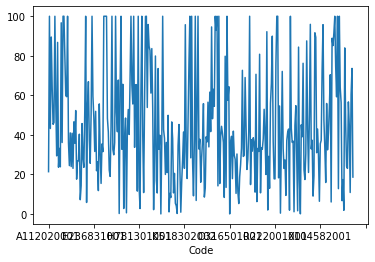

In [46]:
summarygapsstations.PercentageGaps.plot()

(<Figure size 1080x2160 with 2 Axes>, <AxesSubplot:>)

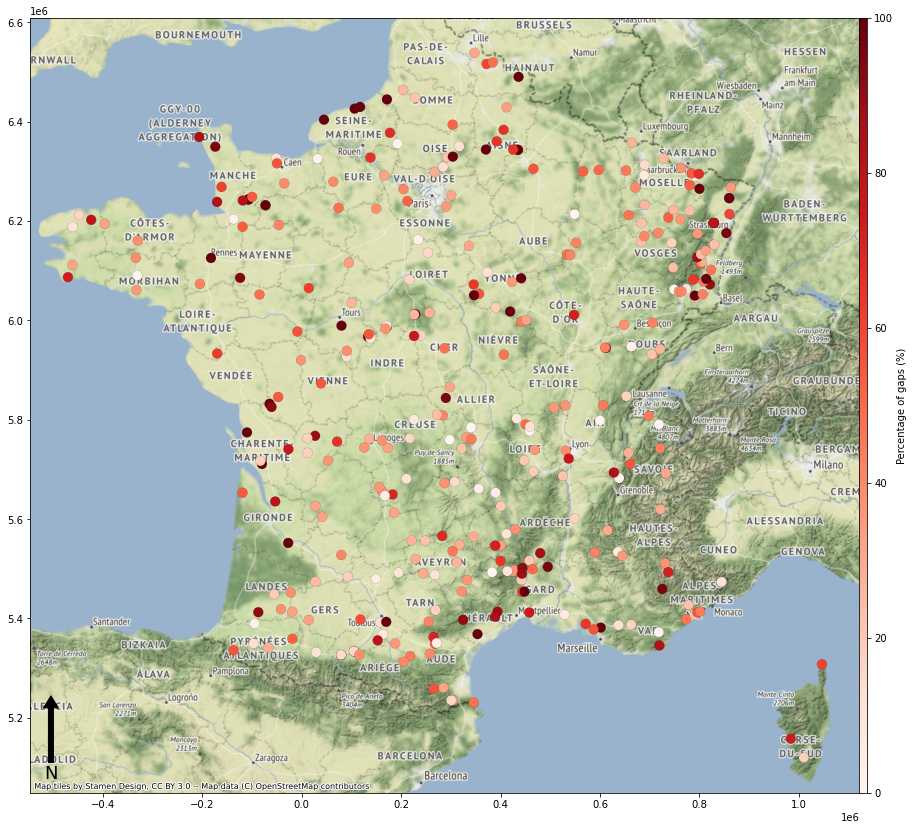

In [48]:
geospatialfunctions.plotgapsmap(summarygapsstations = summarygapsstations, crsproj = 'epsg:4326', backmapproj = True, 
                             figsizeproj = (15, 30), cmapproj = "Reds", markersize_map = 100)

(<Figure size 1080x2160 with 1 Axes>, <AxesSubplot:>)

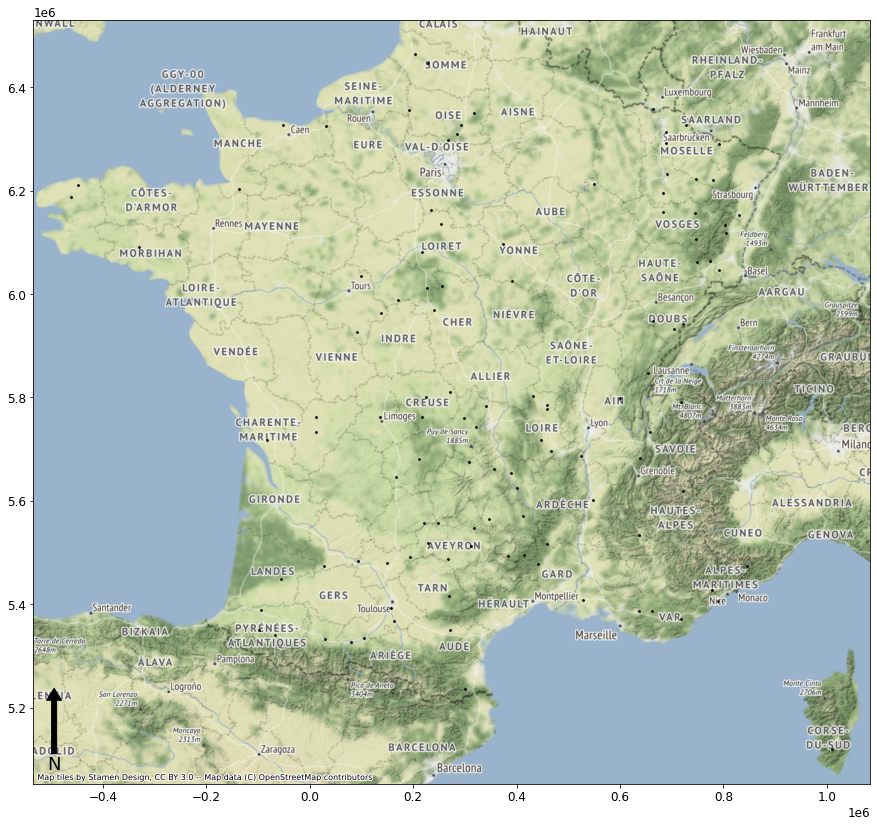

In [50]:
geospatialfunctions.plotpointsmap(summarygapsstations[summarygapsstations.PercentageGaps < 30.0], showcodes = False)

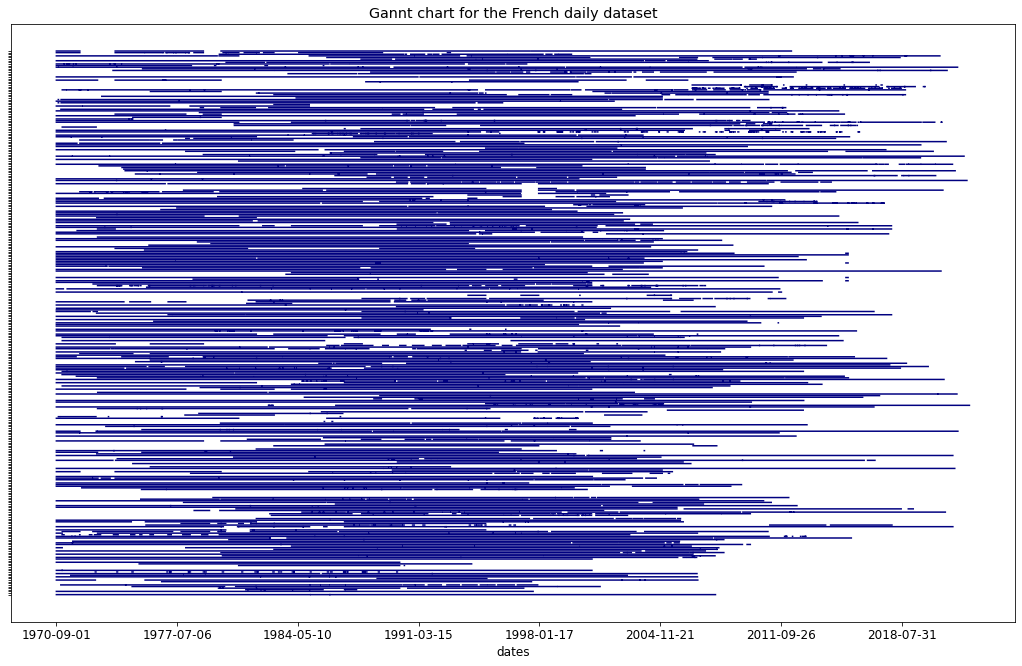

In [52]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal, figsize_chart = (18, 11), 
                                   showcodes = False,
                                   color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                   title_chart = "Gannt chart for the French daily dataset")

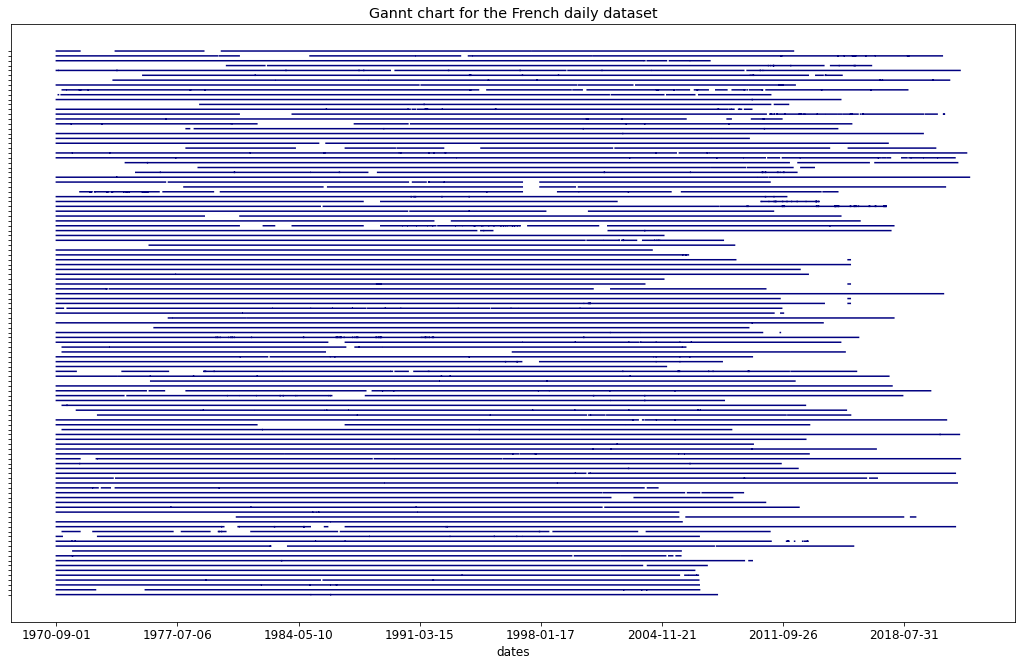

In [58]:
figplot, axesplot = geospatialfunctions.plotganntchart(timeseriesfinal_gantt = timeseriesfinal.loc[:, summarygapsstations[summarygapsstations.PercentageGaps < 30.0].index.tolist()], 
                                                       
                                                       figsize_chart = (18, 11), showcodes = False,
                                                       color_chart = "navy", fontsize_chart = 12,facecolor_chart = "white", 
                                                       title_chart = "Gannt chart for the French daily dataset")

In [57]:
idcondition = summarygapsstations[summarygapsstations.PercentageGaps < 30.0].index.tolist()

timeseriesfinalcondition = timeseriesfinal.loc[:, idcondition]
timeseriesfinalcondition

A112020001  A204010101  A212020002  A235020002  A414020202  \
dates                                                                    
1970-09-01        0.45        1.40        1.04       0.461        3.07   
1970-09-02        0.38        1.38        1.04       0.426        2.69   
1970-09-03        0.38        1.25        1.03       0.376        2.70   
1970-09-04        0.32        1.28        1.02       0.352        2.78   
1970-09-05        0.32        1.49        1.39       0.685        5.41   
...                ...         ...         ...         ...         ...   
2022-09-26         NaN         NaN         NaN         NaN         NaN   
2022-09-27         NaN         NaN         NaN         NaN         NaN   
2022-09-28         NaN         NaN         NaN         NaN         NaN   
2022-09-29         NaN         NaN         NaN         NaN         NaN   
2022-09-30         NaN         NaN         NaN         NaN         NaN   

            A526102003  A542201001  A662121202  A681201001  A695301001  ...  \
dates                                                                   ...   
1970-09-01        1.94       0.100       1.000       0.345         NaN  ...   
1970-09-02        1.55       0.078       0.903       0.345         NaN  ...   
1970-09-03        1.32       0.076       0.915       0.345         NaN  ...   
1970-09-04        1.27       0.082       0.855       0.345         NaN  ...   
1970-09-05        1.21       0.101       1.040       0.345         NaN  ...   
...                ...         ...         ...         ...         ...  ...   
2022-09-26         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-27         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-28         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-29         NaN         NaN         NaN         NaN         NaN  ...   
2022-09-30         NaN         NaN         NaN         NaN         NaN  ...   

            Y025502001  Y141621001  Y400201001  Y430651001  Y500521001  \
dates                                                                    
1970-09-01         NaN         NaN       0.004         NaN         NaN   
1970-09-02         NaN         NaN       0.004         NaN         NaN   
1970-09-03         NaN         NaN       0.003         NaN         NaN   
1970-09-04         NaN         NaN       0.004         NaN         NaN   
1970-09-05         NaN         NaN       0.004         NaN         NaN   
...                ...         ...         ...         ...         ...   
2022-09-26         NaN         NaN         NaN         NaN         NaN   
2022-09-27         NaN         NaN         NaN         NaN         NaN   
2022-09-28         NaN         NaN         NaN         NaN         NaN   
2022-09-29         NaN         NaN         NaN         NaN         NaN   
2022-09-30         NaN         NaN         NaN         NaN         NaN   

            Y521502001  Y560521001  Y561621401  Y661401001  Y881000102  
dates                                                                   
1970-09-01         0.0         NaN        0.18       0.975       0.482  
1970-09-02         0.0         NaN        0.17       0.975       0.351  
1970-09-03         0.0         NaN        0.16       0.975       0.323  
1970-09-04         0.0         NaN        0.15       0.975       0.295  
1970-09-05         0.0         NaN        0.15       0.975       0.323  
...                ...         ...         ...         ...         ...  
2022-09-26         NaN         NaN         NaN         NaN         NaN  
2022-09-27         NaN         NaN         NaN         NaN         NaN  
2022-09-28         NaN         NaN         NaN         NaN         NaN  
2022-09-29         NaN         NaN         NaN         NaN         NaN  
2022-09-30         NaN         NaN         NaN         NaN         NaN  

[19023 rows x 113 columns]

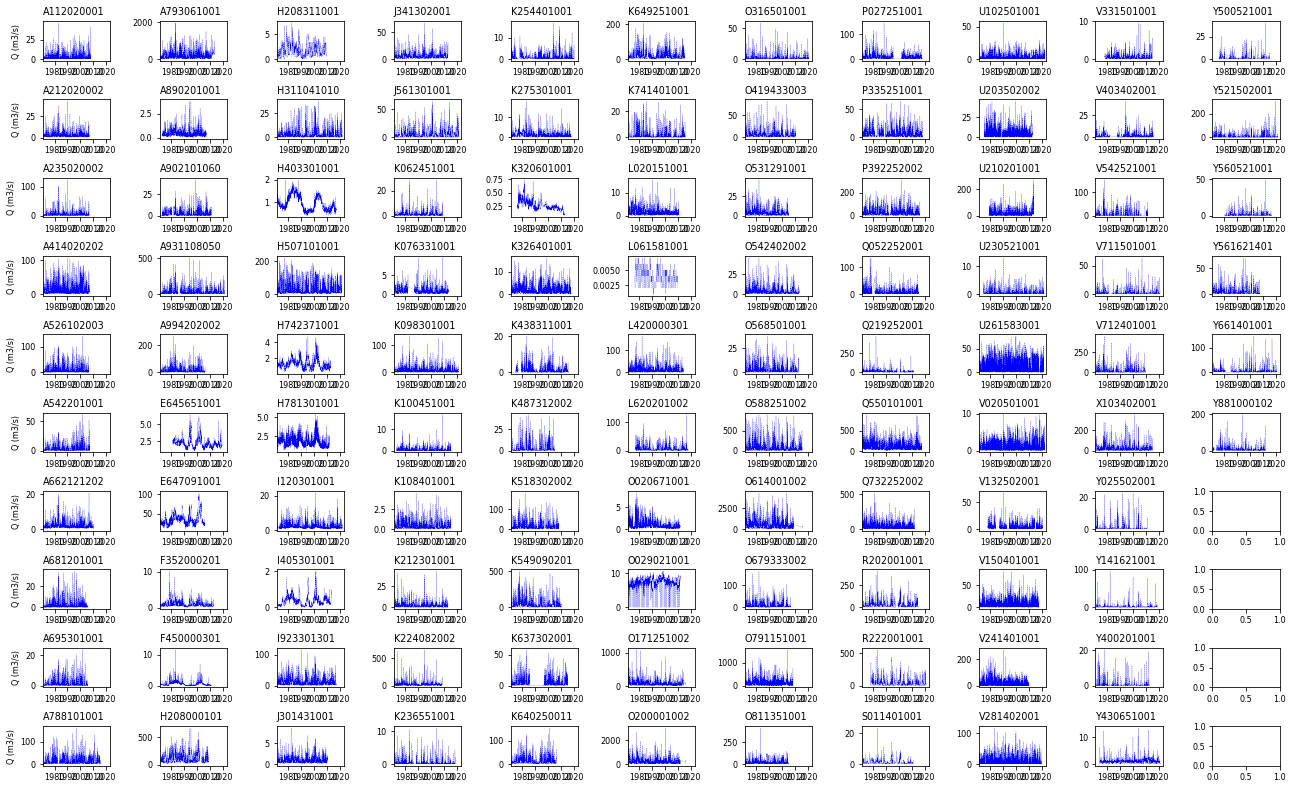

In [115]:
figplot, axesplot = geospatialfunctions.plottimeseries(numr = 10, numc = 11, datatoplot = timeseriesfinalcondition, setylim = False, ymin = 0, ymax = 1, figsizeproj = (18, 11),
                   colorgraph = "blue", linewidthproj = 0.2, linestyleproj = "-.",  ylabelplot = "Q (m3/s)",
                   datestart = datetime.date(1970, 10, 1), dateend = datetime.date(2022, 9, 30),
                   setnumberofintervals = False, numberintervals = 2)